# C$_{60}$: Buckminsterfullerene
Guido Raos, Politecnico di Milano, April 2025 (guido.raos@polimi.it)

In this notebook we will familiarize ourselves with C$_{60}$, the prototypical [fullerene](https://en.wikipedia.org/wiki/Fullerene). In 1996, Harold Kroto, Robert Curl and Richard Smalley were awarded the Chemistry Nobel Prize for its discovery (see [this paper](https://www.nature.com/articles/318162a0) in Nature in 1985, from which I have borrowed the title). This discovery may be considered a starting point for the subsequent development of "nanotechnologies" and "nanomaterials".  

We will use some computationally cheap semiempirical DFT and HF methods implemented within ORCA to determine:
* Its minimum-energy geometry and vibrational frequencies;
* The interaction energy between two fullerene molecules;
* The energies of its low-lying electronic states (if I/we have time...).

## Structure of C$_{60}$

The C$_{60}$ molecule is *almost* spherical, just like a soccer ball:

![soccer ball](https://upload.wikimedia.org/wikipedia/commons/1/1d/Football_Pallo_valmiina-cropped.jpg)

The picture of the soccer ball highlights that some faces are pentagonal, others hexagonal. In *all* fullerenes (sphere-like carbon cages with formula C$_n$, with $n \ge 12$), the number of pentagons is exactly 12 (independently of $n$). This can be derived from [Euler's theorem](https://en.wikipedia.org/wiki/Euler_characteristic), which states that the number of vertices ($v$), edges ($e$) and faces ($f$) in a convex polyhedron are related by:

$v - e + f = 2$

(the proof requires one additional "chemical" assumption, that all carbon atoms are hybridized $sp^2$ and therefore form exactly three bonds).

**Your turn: can you prove it?** \[Hint: express $v$, $e$ and $p$ as a function of the number of pentagons ($p$) and hexagons ($h$), and see where this leads you\].

Note that C$_{60}$ is the smallest fullerene where the pentagons do not share any edges. Edge-sharing pentagons introduce some additional strain in the structure of fullerenes.


As a side note, it is interesting to observe that also many viruses have a fullerene-like capsid (the capsid is protein shell enclosing the nucleic acids, can is disassembled when the virus manages to enter a cell and infects it):

![viruses](https://cdn.rcsb.org/pdb101/motm/200/200-Quasisymmetry_in_Icosahedral_Viruses-Quasisymmetry.jpg)

Check out the PDB-101 web site for further information: https://pdb101.rcsb.org/motm/200

The symmetry of C$_{60}$ is described by the $I_h$ point group, the same as an [icosahedron](https://en.wikipedia.org/wiki/Regular_icosahedron).
Several properties can be derived by **group theory** (see e.g. the Wikipedia article on [molecular symmetry](https://en.wikipedia.org/wiki/Molecular_symmetry)), based on the knowledge of its symmetry alone (i.e., without any need to know its exact geometry or even its chemical composition). For example, the "character tables" of the group tell us that it admits up five-fold degeneracy of its molecular orbitals and its vibrational modes:
* http://symmetry.jacobs-university.de/cgi-bin/group.cgi?group=906&option=4
* http://gernot-katzers-spice-pages.com/character_tables/Ih.html

Three- and four-fold degeneracies are also possible, but not two-fold ones.
If C$_{60}$ were a perfect sphere, its symmetry group would be "O(3)" (a continuous group). In this case, its molecular orbitals would have the same symmetries and degeneracies of atomic orbitals, i.e. they would be of type $s$ (totally symmetric, non-degenerate), $p$ (3-fold degenerate), $d$ (5-fold degenerate), $f$ (7-fold generate), etc. 

A starting structure (with atomic coordinates) for the C$_{60}$ molecule can be downloaded from (for example):
* https://nanotube.msu.edu/fullerene/  (.xyz file)
* https://www.chemspider.com/Chemical-Structure.110185.html  (.mol file)

Download the first one and save it in the currect directory.

In [8]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [9]:
# No need to use complicated file-reading instructions in this case
c60coords = np.loadtxt("C60-Ih.xyz",skiprows=2, usecols=(1,2,3))
print( np.shape(c60coords) )
nc = np.shape(c60coords)[0]

#print(c60coords)
center = np.average( c60coords, axis=0)
print("Molecular center (old):", center)
c60coords -= center
#print(c60coords)
center = np.average( c60coords, axis=0)
print("Molecular center (new):", center)
radius = 0
for c in c60coords:
    dist = np.sqrt( c[0]**2 + c[1]**2 + c[2]**2 )   # We could have used numpy.linalg.norm
    radius += dist
radius /= nc
print("Molecular 'bare' radius:", radius)
dradius = radius + 1.7  # Add Van der Waals radius of C
print("Molecular 'dressed' radius:", dradius)


(60, 3)
Molecular center (old): [-0.00226167  0.005785   -0.00843333]
Molecular center (new): [-1.74050589e-17  7.26270895e-17  1.48029737e-17]
Molecular 'bare' radius: 3.442473449390457
Molecular 'dressed' radius: 5.142473449390457


We will optimize the structure of C60 using the "GNF2-XTB" method by the group of S. Grimme (Germany). This can be described as a semiempirical DFT method, combining low computational cost with the capability to describe molecular geometries and non-bonded interactions reasonably well.

Here is some basic information, coming from this review:
C. Bannwarth, et al. "Extended Tight-Binding Quantum Chemistry Methods". *WIREs Computational Molecular Science* **2021**, 11 (2), e1493. https://doi.org/10.1002/wcms.1493.


> ...The renaissance of semiempirical methods in the last 20 years was mainly caused by the development of density functional tight binding (DFTB) methods by Seifert, Elstner, Frauenheim, and coworkers. The DFTB methods combine the efficiency of the old ZDO type minimal basis set methods with the higher (compared to a Hartree–Fock, HF) accuracy of DFT as the underlying machinery.
> 
> ...Mainly due to the use of a small minimal AO basis set to express the simplified Kohn–Sham (KS) equations analytically, not all desired properties can be described at a similar target accuracy. The computation of accurate chemical bond or reaction energies is particularly difficult at any semiempirical level...
> 
> The GFNn-xTB methods (n = 0, 1, 2, see below) are designed from the very beginning as special purpose tools focusing on molecular properties which can relatively easily and in a physically sound manner be described at low-level, namely geometries, (vibrational) frequencies, and noncovalent interactions (NCIs) leading to the acronym GFN. Chemical energies (stronger interactions) are not used as primary training data but merely define important cross-checks..."

See [the ORCA manual](https://www.faccts.de/docs/orca/6.0/manual/contents/detailed/model.html#semi-empirical-tight-binding-methods-grimme-s-gfn0-xtb-gfn-xtb-and-gfn2-xtb) for instructions on using the XTB family of methods within ORCA. (On my Windows PC, I only had to copy the file "C:\ORCA_6.0.1\xtb-6.7.1pre\xtb.exe" to "C:\ORCA_6.0.1\otool_xtb,.exe").


In [11]:
# Write an ORCA input file with the desired geometry and input parameters
# Here we will use a semiempirical DFT method (the GNF2-XTB by the group of Grimme)

with open('C60_opt.inp', 'w') as f:
    input1 = "# My ORCA input\n" + "! GFN2-XTB TightSCF TightOpt PrintMOs freq\n" + "* xyz 0 1\n"
    f.write(input1)
    for c in c60coords:
        line = "C " + str(c[0]) + " " + str(c[1]) + " " + str(c[2]) + "\n"
        f.write(line)
    input2 = "*"
    f.write(input2)

# Check that file has been written
!dir *.inp

 Il volume nell'unit… C Š Windows
 Numero di serie del volume: 4E52-4D65

 Directory di C:\Users\raos\OneDrive - Politecnico di Milano\Documenti\GUIDO\Didattica\MolecularModeling\Notebooks\C60

08/04/2025  09:49             7'407 C60_C60.inp
08/04/2025  09:49             3'395 C60_opt.inp
               2 File         10'802 byte
               0 Directory  618'149'838'848 byte disponibili


In [12]:
orca_exe  = 'C:\\ORCA_6.0.1\\orca.exe'

def run_orca(input_file):
    print("Running ORCA calculation for", input_file)
    output_file = input_file.replace(".inp", ".log")
    # the "!" character sends the line as an instruction to the operating system
    !{orca_exe} {input_file} > {output_file}      
    print("Calculation completed. Output written to", output_file)
    return output_file


In [13]:
output_file = run_orca("C60_opt.inp")

with open(output_file) as f:
    success = False
    for line in f:
        if "FINAL SINGLE POINT ENERGY" in line:
            ls = line.split()
            energy1 = float( ls[-1] )
            print(energy1)
        elif "HURRAY" in line:
            success = True
            break
     
if success:
    print("The optimization was successful!")
    print("Final energy of optimized molecule:", energy1)
else:
    print("The optimization was NOT successful!")


Running ORCA calculation for C60_opt.inp
Calculation completed. Output written to C60_opt.log
-128.32549568149
-128.41442448897
-128.45628513108
-128.46312540255
-128.46348074281
-128.46351833649
-128.46352517448
-128.46352651284
The optimization was successful!
Final energy of optimized molecule: -128.46352651284


Let us inspect the output:
* How close are the final C-C bond lengths, compared to the starting/experimental ones?
* Are these bonds identical? Why?
* Note down the energies of the HOMO and LUMO energies, and the HOMO-LUMO gap. Are these energy levels *exactly* or *approximately* degenerate? Why?
* Look at the vibrational frequencies and animate a few the corresponding modes... There are many of them!

Note that only a few vibrational transitions are IR-allowed (i.e., have a non-zero intensity in the IR spectrum). Some others will be Raman-allowed (they are mutually exclusive because the molecule has a center of symmetry, see https://en.wikipedia.org/wiki/Rule_of_mutual_exclusion). The ORCA output ("C60_opt" file) does not contain the IR intensities, but these can be found inside the "C60_opt.vibspectrum" file.

Note also that ORCA makes very limited use of symmetry and, due to numerical noise in the definition of the atomic coordinates, our C$_{60}$ molecule is slightly asymmetric, even in the final optimized structure. Therefore, all the vibrational modes in the "C60_opt.vibspectrum" file are classified as "A" (the irreducible representation for the "C1" point group, i.e. no symmetry).

## Interaction of two C$_{60}$ molecules

We want to compute the interaction between two C$_{60}$, as a function of their center-to-center distance.
We will assume the molecules to be rigid and neglect the (possible, but small) changes in their molecular geometries as a function of distance.
For the moment, we will also neglect the orientation-dependence of the interaction (the molecules are not truly spherical).

In [17]:
# We first re-read the coordinates of the optimized molecule.

c60coords = np.loadtxt("C60_opt.xyz",skiprows=2, usecols=(1,2,3))
nc = np.shape(c60coords)[0]
#print(c60coords)
center = np.average( c60coords, axis=0)
c60coords -= center
radius = 0
for c in c60coords:
    dist = np.sqrt( c[0]**2 + c[1]**2 + c[2]**2 )   # We could have used numpy.linalg.norm
    radius += dist
radius /= nc
print("Molecular 'bare' radius:", radius)
dradius = radius + 1.7  # Add Van der Waals radius of C
print("Molecular 'dressed' radius:", dradius)


Molecular 'bare' radius: 3.524219742534254
Molecular 'dressed' radius: 5.224219742534254


In [18]:
# We prepare a series of input files with two molecules, displaced along z

# (to investigate the effect of non-spericity, we should consider other directions and/or rotate the molecules).

delta_start = 8.75
delta_stop = 16.0
npoints = 30
distance = np.linspace(delta_start,delta_stop,num=npoints,endpoint=True)
energy = np.zeros(npoints)
i = -1
for d in distance:
    i += 1
    delta = [0.0, 0.0, d]
    input_file = "C60_C60-"+str(d)+".inp"     # This defines a different file name for each calculation
    input_file = "C60_C60.inp"                # Or use this one to overwrite each input and output file
    with open(input_file, 'w') as f:
        # Note: we *must* use the "TightSCF" option to compute the (small, weak) interaction energy
        input1 = "# Two interacting C60 molecules\n" + "! GFN2-XTB TightSCF \n" + "* xyz 0 1\n"
        f.write(input1)
        # Molecule 1
        for c in c60coords:
            line = "C " + str(c[0]) + " " + str(c[1]) + " " + str(c[2]) + "\n"
            f.write(line)
        # Molecule 2
        for c in c60coords:
            line = "C " + str(c[0]+delta[0]) + " " + str(c[1]+delta[1]) + " " + str(c[2]+delta[2]) + "\n"
            f.write(line)
        f.write("*")
    # Now run the calculation
    print("\nThe C60-C60 distance is:", d)
    output_file = run_orca(input_file)
    # Extract the total energy from the output
    with open(output_file) as f:
        for line in f:
            if "FINAL SINGLE POINT ENERGY" in line:
                ls = line.split()
                energy[i] = float( ls[-1] )
                break

print("Energy1=", energy1)
print("2*Energy1=", 2*energy1)
print("Energy=", energy)

Eh_to_kJmol = 2625.5
energy = (energy-2*energy1)*2625.5

print(distance)
print(energy)

# Check that files have been written
!dir *.inp *.log


The C60-C60 distance is: 8.75
Running ORCA calculation for C60_C60.inp
Calculation completed. Output written to C60_C60.log

The C60-C60 distance is: 9.0
Running ORCA calculation for C60_C60.inp
Calculation completed. Output written to C60_C60.log

The C60-C60 distance is: 9.25
Running ORCA calculation for C60_C60.inp
Calculation completed. Output written to C60_C60.log

The C60-C60 distance is: 9.5
Running ORCA calculation for C60_C60.inp
Calculation completed. Output written to C60_C60.log

The C60-C60 distance is: 9.75
Running ORCA calculation for C60_C60.inp
Calculation completed. Output written to C60_C60.log

The C60-C60 distance is: 10.0
Running ORCA calculation for C60_C60.inp
Calculation completed. Output written to C60_C60.log

The C60-C60 distance is: 10.25
Running ORCA calculation for C60_C60.inp
Calculation completed. Output written to C60_C60.log

The C60-C60 distance is: 10.5
Running ORCA calculation for C60_C60.inp
Calculation completed. Output written to C60_C60.log



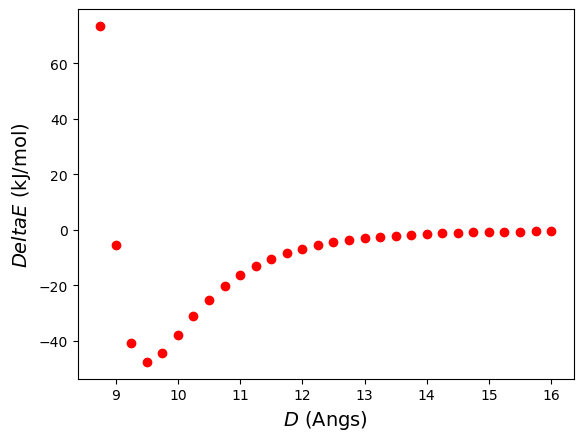

In [19]:
plt.plot(distance, energy, 'r o')
plt.xlabel('$D$ (Angs)', size=14)
plt.ylabel('$Delta E$ (kJ/mol)', size=14)
plt.show()

## Fitting of the C$_{60}$-C$_{60}$ interaction potential

We will try to fit the potential with:
* An "expanded Lennard-Jones" potential. This an empirical model for the interaction of nanoparticles two particles with a "hard core":
  \begin{equation}
  U_{ELJ}(D) = 4\epsilon \left[ \left(\frac{\sigma}{D-\Delta}\right)^{12} - \left(\frac{\sigma}{D-\Delta}\right)^{6} \right]
  \end{equation}
  Here $\Delta$ is an additional fit parameter, that should be of the order of 8 Angs (sum of the radii of two fullenere molecules).
* The "Girifalco potential", which is derived and described in this paper: L.A Girifalco, "Molecular Properties of Fullerene in the Gas and Solid Phases", *J. Phys. Chem.* **1992**, 96 (2), 858–861. https://doi.org/10.1021/j100181a061. The potential was derived by summing (integrating analytically) the pairwise interactions for the C atoms over the surfaces of two spheres. See also "Hamaker theory": https://en.wikipedia.org/wiki/Hamaker_theory

Note that poth potentials are spherically symmetric (they depend only on the interparticle distance $D$).


Optimized ELJ params: sigma= 4.150931335899807  epsilon= 47.82472664064376 delta= 4.836697980813469


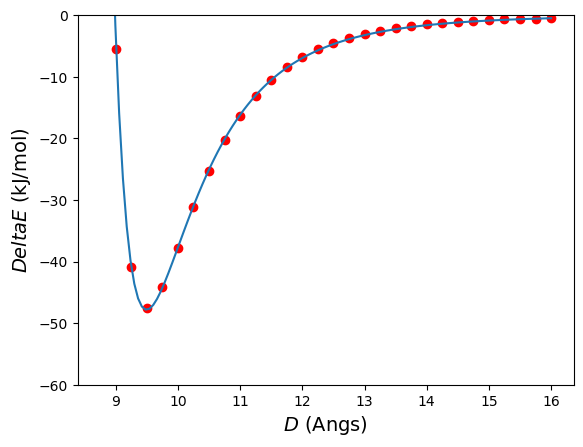

In [22]:
def UELJ(r, sigma=1.0, epsilon=1.0, delta=0.0):
    """Computes the Expanded LJ interaction energy for two atoms, at distance r"""
    ddd = delta*np.ones(np.shape(r))
    sr6 = (sigma / (r-ddd))**6
    energy = 4 * epsilon * ( sr6**2 - sr6 )
    return energy

# Note: I had to experiment a little with the "bounds" in order to get a resonable fit.
popt, pcov = opt.curve_fit(UELJ, distance[2:], energy[2:], bounds=([0,30,4.],[5,60,9.]))
sigma, epsilon, delta = popt
print("Optimized ELJ params: sigma=", sigma, " epsilon=", epsilon, "delta=", delta)

R = np.linspace(distance[0],distance[-1],120)
Efit = UELJ(R, sigma, epsilon, delta)
plt.plot(distance, energy, 'r o')
plt.plot(R, Efit)
plt.xlabel('$D$ (Angs)', size=14)
plt.ylabel('$Delta E$ (kJ/mol)', size=14)
plt.ylim((-60,00))
plt.show()

The fit with the the expanded LJ potential "looks ok", thanks to the additional parameter. Note however that the final value of $\sigma$ is greater than could be expected (it is much bigger than 3.4 Angs, which is the Van der Waals diameter of C), whereas $\Delta$ is smaller that could be expected (it is much smaller than the "bare" radius of C$_{60}$, that we have computed above). Thus, they seem to compensate each other, but we cannot give any real physical significance to their values. This is a common problem, when you are "overfitting" your data.

> Quote of the day:
> 
> "With four parameters I can fit an elephant, and with five I can make him wiggle his trunk." (John von Neumann, as reported by Enrico Fermi).
>
> See this article on Wikipedia: https://en.wikipedia.org/wiki/Von_Neumann%27s_elephant


Let us now try the Girifalco potential, instead. This also contains three adjustable parameters, but it is more physically justificated. It assumes that within a molecule there are 60 carbon atoms that are "evenly spread" on a sphere of radius $a$. The individual C atoms interact by the following pairwise potential:
 \begin{equation}
  U_{CC}(r) = \frac{B}{r^{12}} - \frac{A}{r^{6}}
 \end{equation}
with the following parameters:
* $A = 32.00 \times 10^{-60}$ erg/cm$^6$
* $B = 55.77 \times 10^{-105}$ erg/cm$^{12}$.

**Your turn:** show that the potential above is equivalent to a standard Lennard-Jones potential (see above, with $\Delta=0$), and derive the corresponding parameters $\sigma$ (in Angs) and $\epsilon$ (in kJ/mol).
* $\sigma=...$
* $\epsilon=...$


Optimized Girifalco params: a2= 6.48483975283583  alpha= 11.11412667795946 beta= 0.03502543050781033


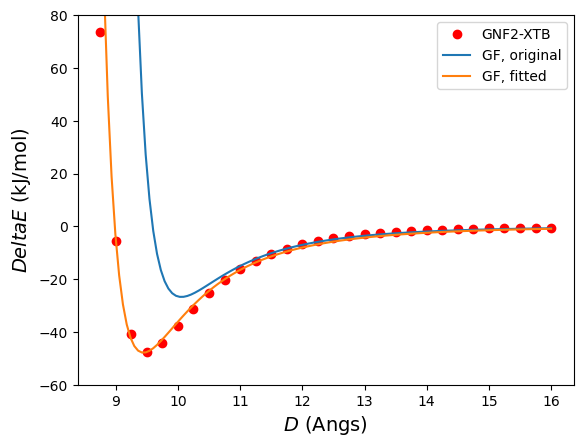

In [25]:
def UGF(r, a2=7.1, alpha=4.513, beta=0.0081871):
    """Computes the Girifalco potential for two C60 molecules, at distance r"""
    # The default values of the three parameters correspond to those in the Girifalco paper
    # a2 (=2a) = 7.1 Angs
    # alpha = 74.95E-15 erg (converted to kJ/mol)
    # beta = 135.95E-18 erg (converted to kJ/mol)
    s = r/a2
    si = 1./s
    term1 = si/(s-1.)**3 + si/(s+1.)**3 - 2.*si**4  # This is the attractive part of the potential
    term2 = si/(s-1.)**9 + si/(s+1.)**9 - 2.*si**10 # This is the repulsive part of the potential
    energy = -alpha*term1 + beta*term2
    return energy

R = np.linspace(distance[0],distance[-1],120)
Eoriginal = UGF(R)   # The Girifalco potential with the original parameters

# We now obtain the parameters of the same potential that fit our ORCA-calculated points. 
popt, pcov = opt.curve_fit(UGF, distance[1:], energy[1:], bounds=([6.,1.,0.],[8.,25.,0.9]))
a2, alpha, beta = popt
print("Optimized Girifalco params: a2=", a2, " alpha=", alpha, "beta=", beta)

Efit = UGF(R, a2, alpha, beta)
plt.plot(distance, energy, 'r o', label="GNF2-XTB")
plt.plot(R, Eoriginal, label="GF, original")
plt.plot(R, Efit, label="GF, fitted")
plt.xlabel('$D$ (Angs)', size=14)
plt.ylabel('$Delta E$ (kJ/mol)', size=14)
plt.ylim((-60,80))
plt.legend()
plt.show()

Comments:
* Compared to the original Girifalco potential (published in 1992), its seems that the GNF2-XTB method overestimates the interaction energy, but underestimates the "size" of the molecules (location of the potential energy minimum). It would be interesting to look for up-to-date experimental data on C$_{60}$ (e.g., densities, surface energies and sublimation entalpies), to decide which one is (more) correct.
* The fit with the Girifalco potential looks "just as good" as with the expanded LJ potential. After all, they both contain three adjustable parameters. So which one is better? It depends. One is physically sounder, whereas the other is simpler and computationally cheaper (important, if we wanted to do Molecular Dynamics or Monte Carlo simulations with thousands of C$_{60}$ molecules).

## Excited electronic states of C$_{60}$

In our course, we have talked almost exclusively about quantum chemical methods (e.g., HF and DFT) that can be used to compute electronic wavefunctions and properties of molecules in their ground state. However, excited-state calculations are also possible.

We want explore the excited electronic states of the C$_{60}$ molecule. These are important (both for applications and from a purely theoretical point of view) and have been extensively studied.

The following paper can be used as a guideline:  K. Andersson, "The Electronic Spectrum of C60". *Chemical Physics Letters* **2020**, 739, 136976. https://doi.org/10.1016/j.cplett.2019.136976.

The above paper uses sophisticated CASSCF/CASPT2 calculations, that we cannot afford to use because of their cost (also, we have not said much about these methods in our theory lectures). Instead, we will compute the excited states by **CIS (configuration interaction with single excitations)** with an "old fashioned" semipirical MO method (AM1, PM3 or INDO/S). Note that GFN2-XTB cannot be used to compute excited state (unlike the *ab initio* versions of DFT, where one could try to do a ["time-dependent DFT"](https://en.wikipedia.org/wiki/Time-dependent_density_functional_theory) calculation, see also the [relevant sections](https://www.faccts.de/docs/orca/6.0/manual/contents/detailed/tddft.html) of the ORCA manual).



In general, a CI calculation can be used both to refine the ground state by accounting for electron correlation effects (lowest root of the "secular problem") and to describe the excited states (higher roots of the secular problem). In particular, the CIS wavefunctions can be written (in symbolic form):
\begin{equation}
\Psi_{CIS} = c_0 \Psi_{HF} + \sum_o^{occupied} \sum_v^{virtual} c_{ov}\Psi(o\rightarrow v)
\end{equation}
where $o$ and $v$ are labels for the occupied and virtual *spin*-orbitals (i.e., they are associated with an $\alpha$ or $\beta$ spins). The coefficients of the expansion, $c_0$ and $c_{ov}$, are determined from the solution of the secular problem and the normalization condition (see lecture slides...).

Note: it can be proven ([Brillouin's theorem](/https://en.wikipedia.org/wiki/Brillouin%27s_theorem)) that the matrix elements of the Hamiltonian between the HF wavefunction and the singly excited determinants are all zero:
\begin{equation}
\left\langle \Psi_{HF} | \cal{H} | \Psi(o\rightarrow v) \right\rangle = 0  \hspace{1cm} (\forall o, v).
\end{equation}
One consequence of this, is that a CIS calculation leaves the ground-state wavefunction and its energy unchanged (i.e., equal to the HF). To introduce some electron correlation within the ground state wavefunction, one must do at least a CISD calculation (i.e., include also doubly excited determinants). Unfortunately, all truncated CI approaches suffer from the lack of "size-consistency" (see again the lecture slides...). The problem probably gets more severe when the size of the system increases (and C$_{60}$ is already pretty large!).

Here is a simple/sample ORCA input, to perform a semiempirical CIS calculation with the ZINDO/S Hamiltonian:
```
! zindo/s TightSCF
! PrintMOs printbasis
%cis
  nroots 60
  maxdim 5
  tda true
  triplets false
end
* xyz 0 1
 C     2.16650   0.59060   2.58740
...
...
*
```
Disclaimer: due to lack of time, I have not tested much the effect of the parameters in the ```%cis``` section of the input.

## Suggestions for further work

The following ideas could evolve into a end-of-course project, to be discussed at the exam:
* Carry out the CIS calculations and discuss the results.
* Study the structure and stablity of higher fullerenest or other materials (e.g., graphene and other 2D materials, also non-carbon-based).
* Have you ever heard of [endohedral fullerene](https://en.wikipedia.org/wiki/Endohedral_fullerene) complexes?
* If you are inclided to study some theory, prepare a report discussing the theoretical basis of one of the methods that have been cited above.
* ... 